In [2]:
#Preprocessing
import sys
sys.path = ['/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages'] + sys.path
import h5py
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib_venn import venn3, venn3_circles
import pickle
import gzip
import pandas as pd
import requests
import math
import pdb
import time
import os
import matplotlib.patches as mpatches
%matplotlib inline

from keras.models import Sequential, Model
from keras.layers import Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input, Dense
from keras.applications.inception_v3 import InceptionV3
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.models import load_model
from keras import backend as K
from scipy.misc import imresize

tissue_types = ['Lung', 'Artery - Tibial', 'Heart - Left Ventricle', 'Breast - Mammary Tissue', 'Brain - Cerebellum', 'Pancreas', 'Testis', 'Liver', 'Ovary', 'Stomach']
genotypes_filepath = '/nfs/research2/stegle/stegle_secure/GTEx/download/49139/PhenoGenotypeFiles/RootStudyConsentSet_phs000424.GTEx.v6.p1.c1.GRU/GenotypeFiles/phg000520.v2.GTEx_MidPoint_Imputation.genotype-calls-vcf.c1/parse_data/GTEx_Analysis_20150112_OMNI_2.5M_5M_450Indiv_chr1to22_genot_imput_info04_maf01_HWEp1E6_ConstrVarIDs_all_chrom_filered_maf_subset_individuals_44_tissues.hdf5'
expression_filepath = '/nfs/research2/stegle/stegle_secure/GTEx/download/49139/PhenoGenotypeFiles/RootStudyConsentSet_phs000424.GTEx.v6.p1.c1.GRU/ExpressionFiles/phe000006.v2.GTEx_RNAseq.expression-data-matrixfmt.c1/parse_data/44_tissues/GTEx_Data_20150112_RNAseq_RNASeQCv1.1.8_gene_rpkm_*_normalised_without_inverse_gene_expression.txt'
phenotype_filepath = '/nfs/research2/stegle/stegle_secure/GTEx/download/49139/PhenoGenotypeFiles/RootStudyConsentSet_phs000424.GTEx.v6.p1.c1.GRU/PhenotypeFiles/phs000424.v6.pht002743.v6.p1.c1.GTEx_Sample_Attributes.GRU.txt.gz'
lung_expression_filepath = '/nfs/research2/stegle/stegle_secure/GTEx/download/49139/PhenoGenotypeFiles/RootStudyConsentSet_phs000424.GTEx.v6.p1.c1.GRU/ExpressionFiles/phe000006.v2.GTEx_RNAseq.expression-data-matrixfmt.c1/parse_data/44_tissues/GTEx_Data_20150112_RNAseq_RNASeQCv1.1.8_gene_rpkm_{}_normalised_without_inverse_gene_expression.txt'.format("Lung")

def build_empty_model():
    inception_model = InceptionV3(weights='imagenet', include_top=False)

    x = inception_model.output

    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(10)(x)

    model = Model(input=inception_model.input, output=predictions)
    return model

def get_donor_IDs(IDlist):
    return [str(x).split('-')[1] for x in IDlist]

def sigmoid(x):
    return 1 / (1 + np.exp(-np.array(x)))

model = build_empty_model()
model.load_weights('../models/inception_50_-1_gs1.h5')

ID = 'GTEX-133LE-0526'
patches = pickle.load(open('../data/processed/covering_patches/Lung/GTEX-133LE-0526/GTEX-133LE-0526_16000', 'rb'))

In [21]:
def maximise_ith_class(image, component):
    print ('generating iteration function')
    # build a loss function that maximizes the activation of the ith filter 
    input_img = model.layers[0].input
    layer_output = model.layers[-1].output
    loss = K.mean(layer_output[:,component])
    # compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]
    # normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    # this function returns the loss and grads given the input picture
    iterate = K.function([K.learning_phase(), input_img], [loss, grads])
    
    print ('performing gradient ascent')
    example_image = imresize(image, (299,299,3)).reshape(1,299,299,3).astype(np.float32)
    input_img_data = example_image.copy()
    original_img_data = example_image.copy()
    step = 0.05
    for i in range(200):
        loss_value, grads_value = iterate([0, input_img_data])
        input_img_data += grads_value * step
        if i % 20 == 0:
            print (i, loss_value)
    
    f,a = plt.subplots(1,2, figsize=(15,5))
    f.suptitle("Class {}".format(component))
    a[0].imshow(255 - np.squeeze(input_img_data))
    a[0].set_title("Modified")
    a[1].imshow(255 - np.squeeze(original_img_data))
    a[1].set_title("Original")

In [21]:
example_image = imresize(patches[10], (299,299,3)).reshape(1,299,299,3).astype(np.float32)

In [22]:
example_image = np.random.randint(0,255,size=[128,128,3]).astype(np.float32)

generating iteration function
performing gradient ascent
0 -5.23116e+06
20 -2.3829e+06
40 -1.23607e+06
60 -769468.0
80 -549342.0
100 -435850.0
120 -367160.0
140 -320742.0
160 -285369.0
180 -258819.0


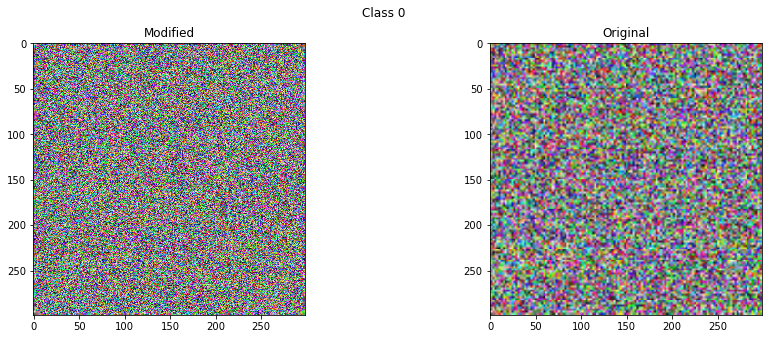

In [23]:
maximise_ith_class(example_image, 0)

In [ ]:
maximise_ith_class(patches[0], 1)

In [ ]:
maximise_ith_class(patches[0], 0)